<a href="https://colab.research.google.com/github/SidharthBhakth/Feedforward-NNs-in-pyTorch/blob/main/04_CIFAR_10_with_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR-10 with data augmentation**

In [ ]:
import numpy as np

import torch
from torch import nn, optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
torch.manual_seed(42)

In [ ]:
# Check if GPU is available
print(torch.cuda.is_available())

# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [ ]:
dataset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

train, val = torch.utils.data.random_split(dataset, [45000, 5000])

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
def apply_transforms(data, transform):
  
  X = []
  y = []

  for image, label in data:
    image = transform(image)
    X.append(image)
    y.append(label)
  
  return torch.stack(X), torch.tensor(y)

In [ ]:
class Dataset(torch.utils.data.Dataset):
  """
  Custom class to apply transforms
  """
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
  
  def __getitem__(self, idx):
    # Generates one sample of data
    image, label = self.images[idx], self.labels[idx]

    return image, label
  
  def __len__(self):
    return len(self.images)

In [ ]:
X_train, Y_train = apply_transforms(data = train, transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
train_set = Dataset(X_train, Y_train)
train_loader = DataLoader(train_set, batch_size=500, shuffle = True)

X_val, Y_val = apply_transforms(data = val, transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
val_set = Dataset(X_val, Y_val)
val_loader = DataLoader(val_set, batch_size=5000, shuffle = True)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = (5, 5), stride = 1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = (2, 2), stride = 2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (5, 5), stride = 1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = (2, 2), stride = 2))
                
        self.fc1 = nn.Sequential(nn.Linear(in_features = 5 * 5 * 10, out_features = 20),
                                 nn.ReLU())
        
        self.fc2 = nn.Sequential(nn.Linear(in_features = 20, out_features = 10),
                                 nn.LogSoftmax(dim = 1))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [ ]:
def init_kaiming(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight)
    m.bias.data.fill_(0.01)

In [ ]:
def training_loop(model, lr=0.001, n_epochs = 200):
  """
  Custom training loop to train neural network
  """
  # Initilize NN class
  NN = model
  NN.apply(init_kaiming)

  # Transfer to GPU
  NN.to(device)

  # hyperparameters
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(NN.parameters(), lr=lr)

  val_accuracy = []

  for epoch in range(n_epochs):
      
      # Train
      NN.train()
      for images, labels in train_loader:        
          X_train, Y_train = images.to(device), labels.to(device)               # Transfer to GPU
          optimizer.zero_grad()                                                 # Set the parameter gradients to zero
          output = NN(X_train)                                                  # Forward pass
          loss = loss_fn(output, Y_train)                                       # Compute loss
          loss.backward()                                                       # Backpropagation
          optimizer.step()                                                      # Optimization
          
      # Validate
      NN.eval()
      with torch.no_grad():
        for images, labels in val_loader:
          X_val, Y_val = images.to(device), labels.to(device)                   # Transfer to GPU
          prediction = NN(X_val)                                                # Predict
          Y_pred = torch.argmax(prediction, dim=1)                              # For each prediction, find the dim with the maximum probability
          accuracy = 100 * (sum(Y_pred == Y_val).item() / len(Y_val))           # Compute accuracy

      # Keep track of validation accuracy for each epoch
      val_accuracy.append(accuracy)

      if (epoch+1) % 20 == 0:
          print("Epoch {} | validation accuracy: {:.2f}%".format(epoch+1, val_accuracy[-1]))
      
  return val_accuracy

In [ ]:
# train baseline model
baseline_val_accuracy = training_loop(model = ConvNet())

Epoch 20 | validation accuracy: 57.20%
Epoch 40 | validation accuracy: 61.14%
Epoch 60 | validation accuracy: 62.72%
Epoch 80 | validation accuracy: 62.70%
Epoch 100 | validation accuracy: 63.52%
Epoch 120 | validation accuracy: 63.56%
Epoch 140 | validation accuracy: 63.94%
Epoch 160 | validation accuracy: 64.70%
Epoch 180 | validation accuracy: 64.48%
Epoch 200 | validation accuracy: 64.50%


In [ ]:
## Data augmentation

# Augmented dataset #1: brighten every pixel by 10%
X_train_aug1, Y_train_aug1 = apply_transforms(data = train, transform = transforms.Compose([transforms.ColorJitter(brightness = (1.1, 1.1)),
                                                                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

# Augmented dataset #2: darken every pixel by 10%
X_train_aug2, Y_train_aug2 = apply_transforms(data = train, transform = transforms.Compose([transforms.ColorJitter(brightness = (0.9, 0.9)),
                                                                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

# Augmented dataset #3: flip all images horizontally
X_train_aug3, Y_train_aug3 = apply_transforms(data = train, transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0),
                                                                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

# Augmented dataset #4: normalize
X_train_aug4, Y_train_aug4 = apply_transforms(data = train, transform = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

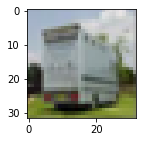

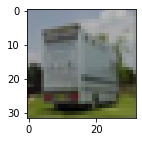

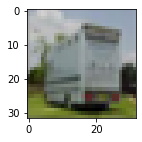

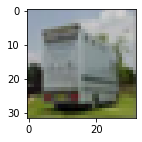

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.figure(figsize = (2,2))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show();

# visualize random training images
idx = np.random.randint(0, 45000)
for dataset in [X_train_aug1, X_train_aug2, X_train_aug3, X_train_aug4]:
  imshow(make_grid(dataset[idx]))

In [ ]:
X_train = torch.cat([X_train_aug1, X_train_aug2, X_train_aug3, X_train_aug4], 0)
Y_train = torch.cat([Y_train_aug1, Y_train_aug2, Y_train_aug3, Y_train_aug4], 0)

train_set = Dataset(X_train, Y_train)
train_loader = DataLoader(train_set, batch_size=500, shuffle = True)

In [ ]:
# train augmened model
augmented_val_accuracy = training_loop(model = ConvNet())

Epoch 20 | validation accuracy: 66.18%
Epoch 40 | validation accuracy: 67.30%
Epoch 60 | validation accuracy: 67.58%
Epoch 80 | validation accuracy: 67.02%
Epoch 100 | validation accuracy: 67.50%
Epoch 120 | validation accuracy: 67.90%
Epoch 140 | validation accuracy: 67.66%
Epoch 160 | validation accuracy: 67.56%
Epoch 180 | validation accuracy: 67.22%
Epoch 200 | validation accuracy: 67.58%


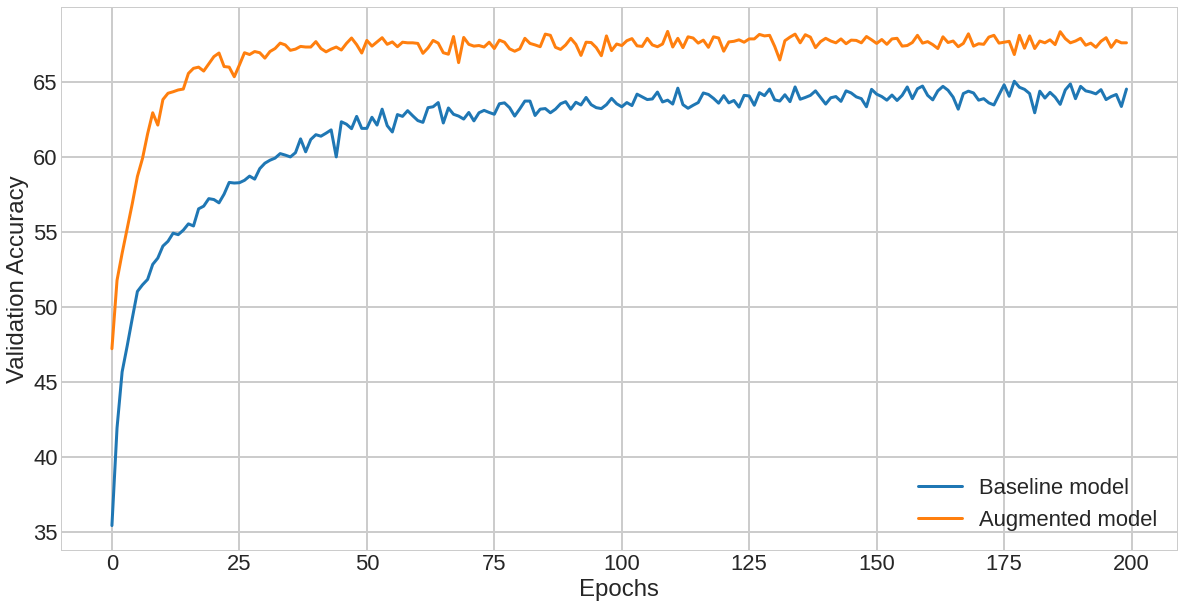

In [ ]:
sns.set_context('poster')
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (20,10))
plt.plot(baseline_val_accuracy, label = 'Baseline model')
plt.plot(augmented_val_accuracy, label = 'Augmented model')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right');

We can see from the plot of validation accuracies of both models that data augementation does indeed increase the validation performance.